# Exploratory figures of the downloaded data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import geopandas as gpd
# import seaborn as sns
import rasterio

data_loc = '/home/waves/data/Africa_Irrigation/Data'
raw_data_dir = os.path.join(data_loc, 'anna', 'raw')
years = range(1980, 2016, 5)

# County Boundaries

   iso3                 status color_code                      name continent  \
0   MNP           US Territory        USA  Northern Mariana Islands   Oceania   
1  None  Sovereignty unsettled        RUS             Kuril Islands      Asia   
2   FRA           Member State        FRA                    France    Europe   
3   SRB           Member State        SRB                    Serbia    Europe   
4   URY           Member State        URY                   Uruguay  Americas   

            region iso_3166_1_               french_shor  \
0       Micronesia          MP  Northern Mariana Islands   
1     Eastern Asia        None             Kuril Islands   
2   Western Europe          FR                    France   
3  Southern Europe          RS                    Serbie   
4    South America          UY                   Uruguay   

                                            geometry  
0  MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...  
1  MULTIPOLYGON (((146.68274 43.70777, 146

<Axes: >

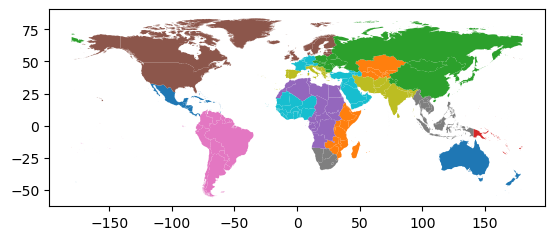

In [2]:
# Load the country boundaries
world_boundaries_path = os.path.join(raw_data_dir, 'world_boundaries', 'world-administrative-boundaries.shp')
world_boundaries = gpd.read_file(world_boundaries_path)

# Plot the country boundaries with the color by region
print(world_boundaries.head())
world_boundaries.plot(column='region')

In [3]:
# Get a list of the countries in Africa based on whether the countinent column is Africa
africa_countries = world_boundaries[world_boundaries['continent'] == 'Africa']
northern_africa_countries = ['Algeria', 'Egypt', 'Libyan Arab Jamahiriya', 'Morocco', 'Sudan', 'Tunisia', 'Western Sahara'] # Libyan Arab Jamahiriya = Libya
ssa_countries = africa_countries[~africa_countries['name'].isin(northern_africa_countries)]

<Axes: >

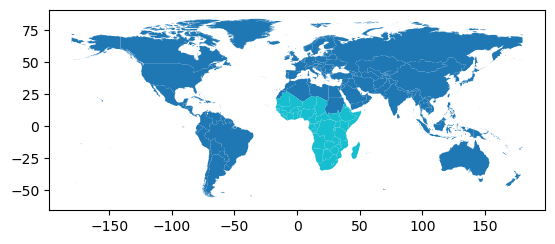

In [4]:
# add a column for whether the country is in SSA
world_boundaries['in_ssa'] = world_boundaries['name'].isin(ssa_countries['name'])

# Plot the country boundaries with the color by whether it's in SSA
world_boundaries.plot(column='in_ssa')

In [7]:
# Save the country boundaries with the in_ssa column
int_wb_dir = os.path.join(data_loc, 'anna', 'intermediate', 'world_boundaries')
os.makedirs(int_wb_dir, exist_ok=True)
world_boundaries.to_file(os.path.join(int_wb_dir, 'world-administrative-boundaries.shp'))

/tmp/ipykernel_3826055/1397015270.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  world_boundaries.to_file(os.path.join(int_wb_dir, 'world-administrative-boundaries.shp'))


# Dam data

Index(['GRAND_ID', 'RES_NAME', 'DAM_NAME', 'ALT_NAME', 'RIVER', 'ALT_RIVER',
       'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY', 'ALT_CITY', 'ADMIN_UNIT',
       'SEC_ADMIN', 'COUNTRY', 'SEC_CNTRY', 'YEAR', 'ALT_YEAR', 'DAM_HGT_M',
       'ALT_HGT_M', 'DAM_LEN_M', 'ALT_LEN_M', 'AREA_SKM', 'AREA_POLY',
       'AREA_REP', 'AREA_MAX', 'AREA_MIN', 'CAP_MCM', 'CAP_MAX', 'CAP_REP',
       'CAP_MIN', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
       'CATCH_REP', 'DATA_INFO', 'USE_IRRI', 'USE_ELEC', 'USE_SUPP',
       'USE_FCON', 'USE_RECR', 'USE_NAVI', 'USE_FISH', 'USE_PCON', 'USE_LIVE',
       'USE_OTHR', 'MAIN_USE', 'LAKE_CTRL', 'MULTI_DAMS', 'TIMELINE',
       'COMMENTS', 'URL', 'QUALITY', 'EDITOR', 'LONG_DD', 'LAT_DD',
       'geometry'],
      dtype='object')


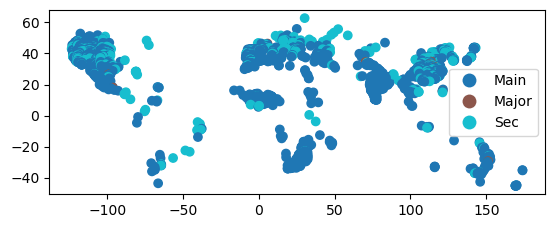

In [5]:
# Load the dam data
dam_data_path = os.path.join(raw_data_dir, 'dams-rev01-global-shp', 'GRanD_dams_v1_1.shp')
dam_data = gpd.read_file(dam_data_path)

print(dam_data.columns)

# Plot the dam data with the color by year
dam_data.plot(column='USE_IRRI', legend=True)
plt.show()

plt.show()


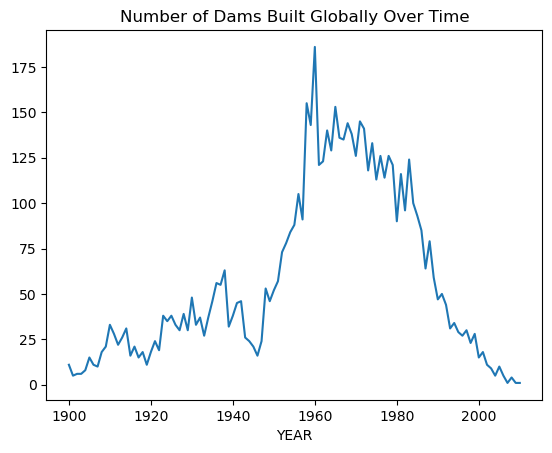

In [6]:
# Plot out the number of dams built over time

# if the year is less than 0, this needs to be converted to nan
dam_data['YEAR'] = dam_data['YEAR'].replace(-99, np.nan)

# Plot the number of dams built but only starting in 1900
dam_data[dam_data['YEAR'] >= 1900].groupby('YEAR').size().plot()
plt.title("Number of Dams Built Globally Over Time")
plt.show()



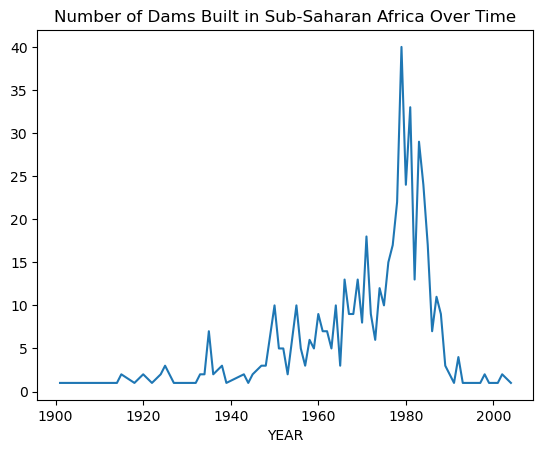

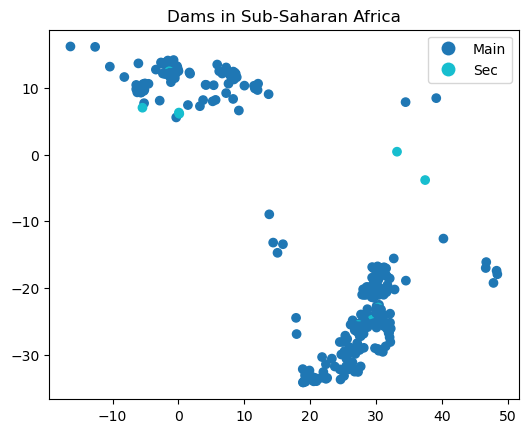

In [7]:
# filter the dams that are within the boundaries of Sub-Saharan Africa and plot the same timeseries
ssa_dam_data = dam_data[dam_data.within(ssa_countries.unary_union)]
ssa_dam_data[ssa_dam_data['YEAR'] >= 1900].groupby('YEAR').size().plot()
plt.title("Number of Dams Built in Sub-Saharan Africa Over Time")
plt.show()

# Also map
ssa_dam_data.plot(column='USE_IRRI', legend=True)
plt.title("Dams in Sub-Saharan Africa")
plt.show()

## Irrigation data

In [8]:
# load all the AEI data into a raster stack and plot it
aei_dir = os.path.join(raw_data_dir, 'AEI')

def load_aei_raster(source='Mehta'):

    # Create an empty list to store the rasters
    rasters = []

    # Loop through each year, load the raster, and add it to the list
    for year in years:
        if source == 'Mehta':
            file_path = os.path.join(aei_dir, f"G_AEI_{year}.ASC")
        elif source == 'Meier':
            file_path = os.path.join(aei_dir, f"MEIER_G_AEI_{year}.ASC")
        else: 
            raise ValueError("source must be 'Mehta' or 'Meier'")
        
        with rasterio.open(file_path) as src:
            rasters.append(src.read(1))  # Read the first band (assuming single-band rasters)

    # Stack the rasters along a new axis
    stacked_rasters = np.stack(rasters, axis=0)
    
    print(f"Stacked raster shape: {stacked_rasters.shape}")
    return stacked_rasters

# Load the Mehta data
mehta_aei = load_aei_raster(source='Mehta')
meier_aei = load_aei_raster(source='Meier')

Stacked raster shape: (8, 2160, 4320)
Stacked raster shape: (8, 2160, 4320)


/tmp/ipykernel_3824272/706385129.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


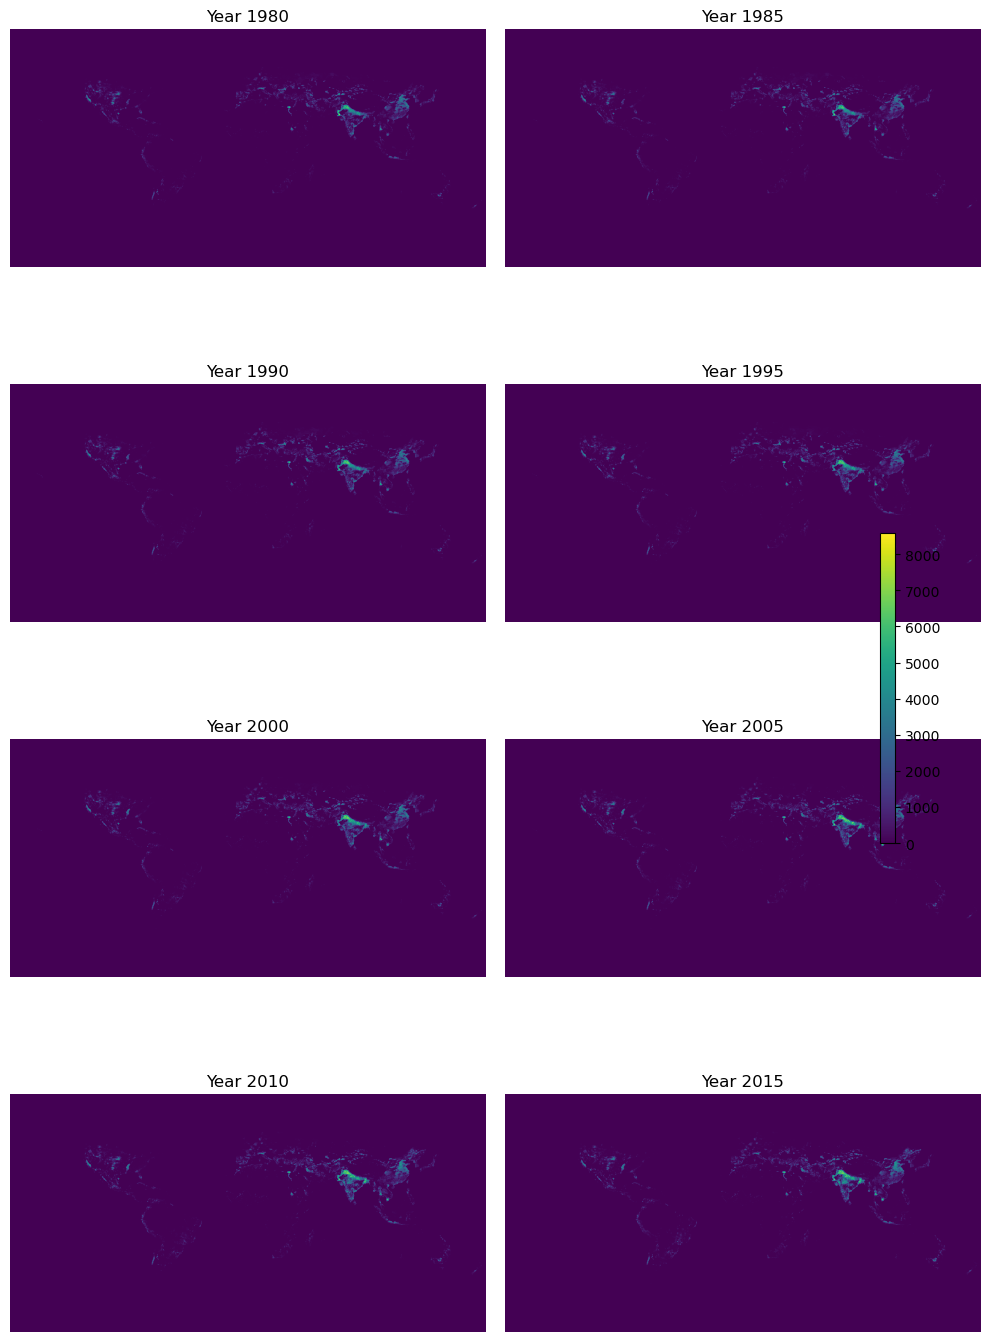

In [9]:
# Plot the Mehta data
# Set the number of rows and columns
rows = 4
cols = 2

# Create a figure with subplots in a 4x2 grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each year and plot the corresponding raster
for i in range(len(mehta_aei)):
    im = axes[i].imshow(mehta_aei[i], cmap='viridis')  # Change colormap as needed
    axes[i].set_title(f"Year {years[i]}")
    axes[i].axis('off')  # Turn off the axis for cleaner plots

# Remove any extra subplots if the number of rasters is less than rows * cols
for i in range(len(mehta_aei), len(axes)):
    fig.delaxes(axes[i])

# Add a colorbar to the last plotted raster
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3824272/1873858081.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


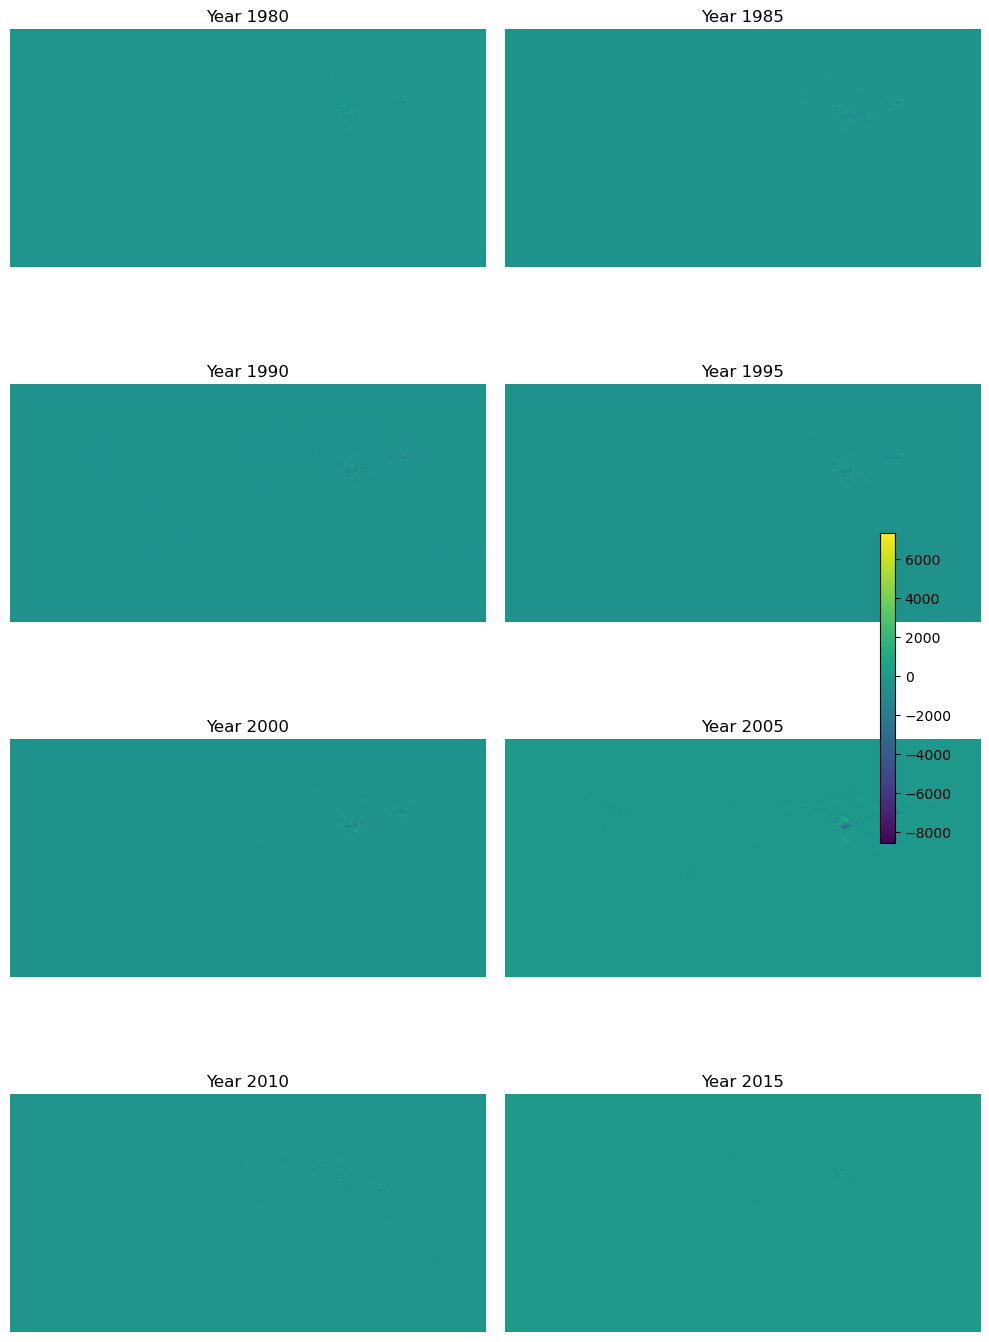

In [10]:
# Plot the difference between the Mehta and Meier data
# Calculate the difference between the two datasets
diff_aei = mehta_aei - meier_aei

# Set the number of rows and columns
rows = 4
cols = 2

# Create a figure with subplots in a 4x2 grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each year and plot the corresponding raster
for i in range(len(diff_aei)):
    im = axes[i].imshow(diff_aei[i], cmap='viridis')  # Change colormap as needed
    axes[i].set_title(f"Year {years[i]}")
    axes[i].axis('off')  # Turn off the axis for cleaner plots

# Remove any extra subplots if the number of rasters is less than rows * cols
for i in range(len(mehta_aei), len(axes)):
    fig.delaxes(axes[i])

# Add a colorbar to the last plotted raster
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()